In [9]:
import numpy as np
from flowrec.utils.system import set_gpu
set_gpu(1,1)
import jax
import jax.numpy
from matplotlib import pyplot as plt
plt.style.use('./flowrec/utils/ppt.mplstyle')
from matplotlib import mlab
from mpl_toolkits.axes_grid1 import ImageGrid
from pathlib import Path
import jax.numpy as jnp

In [10]:
from flowrec.utils.simulation import read_data_kolsol, kolsol_forcing_term
import flowrec.physics_and_derivatives as derivatives
import flowrec.losses as losses
from flowrec.data import DataMetadata, normalise, unnormalise_group
from flowrec.utils.py_helper import slice_from_tuple

In [11]:
# u_p, re, dt = read_data_kolsol('./local_data/kolmogorov/dim3_re34_k32_f4_dt01_grid64_189.h5')
u_p, re, dt = read_data_kolsol('/storage0/ym917/data/simulations/kolsol/dim3_re34_k32_f4_dt01_grid64_1372_t200-250.h5')
# u_p_new, re, dt = read_data_kolsol('/storage0/ym917/data/simulations/kolsol/dim3_re34_k32_f4_dt01_grid64_478_t200-250.h5')
# u_p = np.concatenate([u_p,u_p_new],axis=0)
dt,u_p.shape

(0.1, (500, 64, 64, 64, 4))

In [12]:
u_p = []
for f in [Path('/storage0/ym917/data/simulations/kolsol/dim3_re34_k32_f4_dt01_grid64_478_t200-250.h5'),
        Path('/storage0/ym917/data/simulations/kolsol/dim3_re34_k32_f4_dt01_grid64_478_t360-410.h5'),
        Path('/storage0/ym917/data/simulations/kolsol/dim3_re34_k32_f4_dt01_grid64_1372_t200-250.h5'),
        Path('/storage0/ym917/data/simulations/kolsol/dim3_re34_k32_f4_dt01_grid64_691_t200-250.h5'),
        Path('/storage0/ym917/data/simulations/kolsol/dim3_re34_k32_f4_dt01_grid64_57_t180-230.h5')]:
    u_p_, re, dt = read_data_kolsol(f)
    u_p.append(u_p_)
u_p = np.concatenate(u_p,axis=0)
dt,u_p.shape

(0.1, (2500, 64, 64, 64, 4))

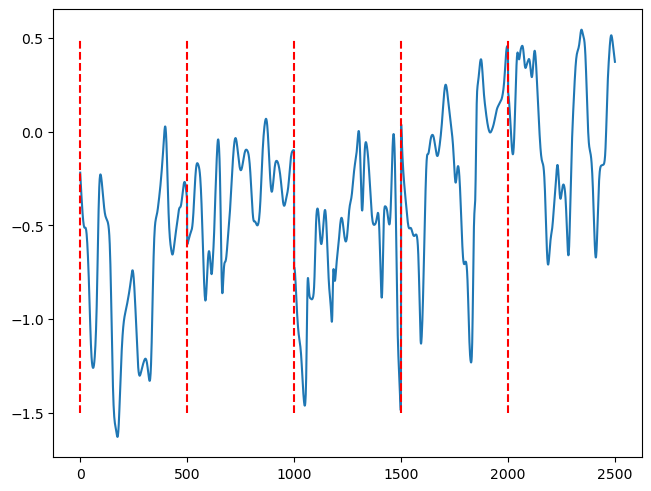

In [13]:
plt.plot(u_p[:,10,10,10,0])
plt.vlines(np.arange(5)*500, -1.5, 0.5, color='r', linestyle='--')

In [14]:
datainfo = DataMetadata(
    re=re,
    discretisation=[dt,2*np.pi/64,2*np.pi/64,2*np.pi/64],
    axis_index=[0,1,2,3],
    problem_2d=False
).to_named_tuple()

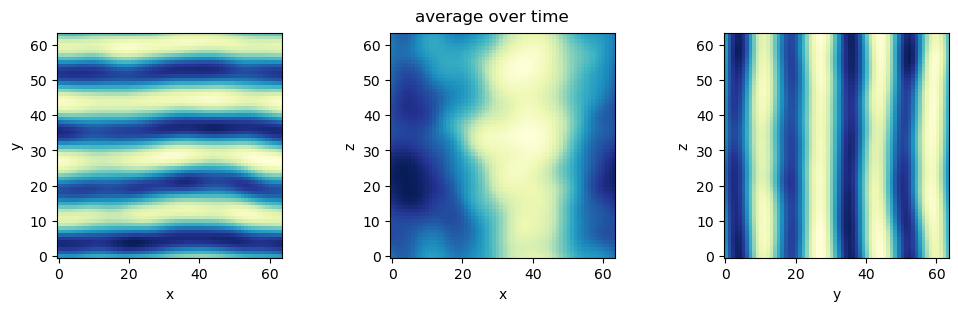

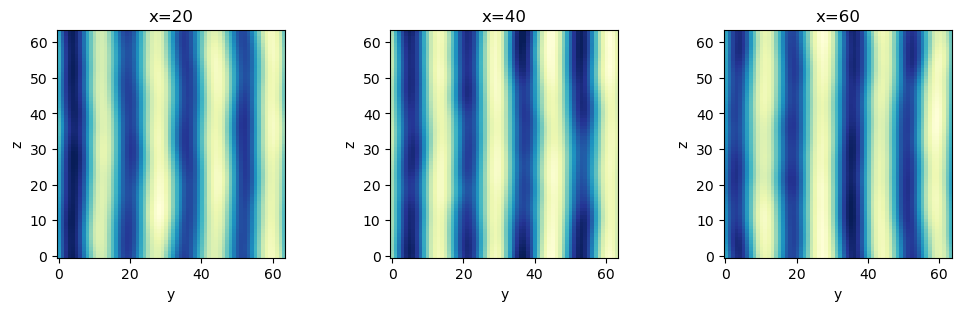

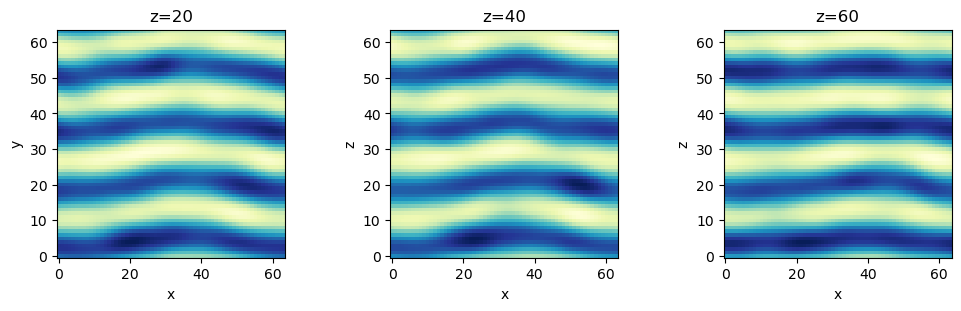

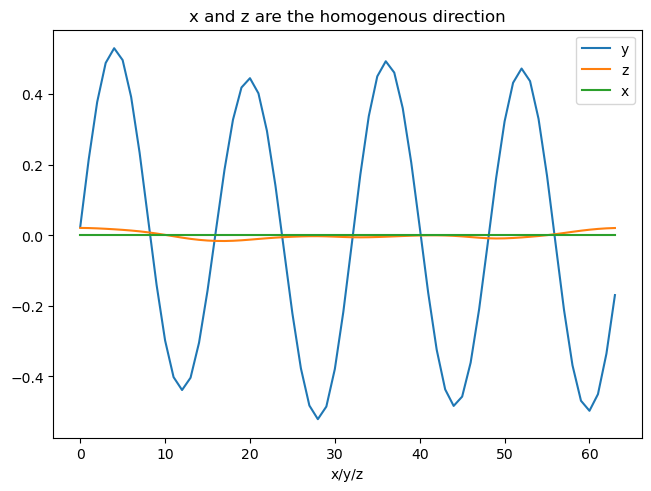

In [15]:
fig, axes = plt.subplots(1,3,figsize=(10,3))
axes[0].imshow(np.mean(u_p[:,:,:,0,0],axis=0).T)
axes[0].set(xlabel='x', ylabel='y')
axes[1].imshow(np.mean(u_p[:,:,0,:,0],axis=0).T)
axes[1].set(xlabel='x',ylabel='z')
axes[2].imshow(np.mean(u_p[:,0,:,:,0],axis=0).T)
axes[2].set(xlabel='y',ylabel='z')
fig.suptitle('average over time')
plt.show()


fig,axes = plt.subplots(1,3, figsize=(10,3))
axes[0].imshow(np.mean(u_p[:,20,:,:,0], axis=0).T)
axes[0].set(xlabel='y', ylabel='z', title='x=20')
axes[1].imshow(np.mean(u_p[:,40,:,:,0], axis=0).T)
axes[1].set(xlabel='y', ylabel='z', title='x=40')
axes[2].imshow(np.mean(u_p[:,60,:,:,0], axis=0).T)
axes[2].set(xlabel='y', ylabel='z', title='x=60')
plt.show()
fig,axes = plt.subplots(1,3, figsize=(10,3))
axes[0].imshow(np.mean(u_p[:,:,:,20,0], axis=0).T)
axes[0].set(xlabel='x', ylabel='y', title='z=20')
axes[1].imshow(np.mean(u_p[:,:,:,40,0], axis=0).T)
axes[1].set(xlabel='x', ylabel='z', title='z=40')
axes[2].imshow(np.mean(u_p[:,:,:,60,0], axis=0).T)
axes[2].set(xlabel='x', ylabel='z', title='z=60')
plt.show()

plt.figure()
plt.plot(np.mean(u_p[...,0], axis=(0,1,3)), label='y')
plt.plot(np.mean(u_p[...,0], axis=(0,1,2)), label='z')
plt.plot(np.mean(u_p[...,0], axis=(0,2,3)), label='x')
plt.title('x and z are the homogenous direction')
plt.xlabel('x/y/z')
plt.legend()
plt.show()

In [16]:
losses.divergence(u_p[...,:-1],datainfo)

Array(0.00023857, dtype=float32)

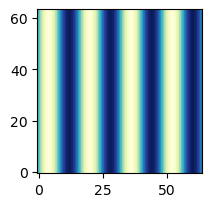

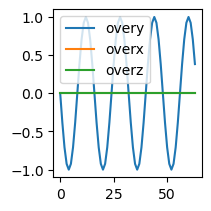

In [17]:
forcing = kolsol_forcing_term(4, 64, 3)
plt.figure(figsize=(2,2))
plt.imshow(forcing[0,0,0,:,:].T)
plt.figure(figsize=(2,2))
plt.plot(forcing[0,0,0,:,0],label='overy')
plt.plot(forcing[0,0,:,0,0],label='overx')
plt.plot(forcing[0,0,0,0,:],label='overz')
plt.legend()
plt.show()

In [18]:
mfield = derivatives.momentum_residual_field(u_p[:200,...], datainfo)

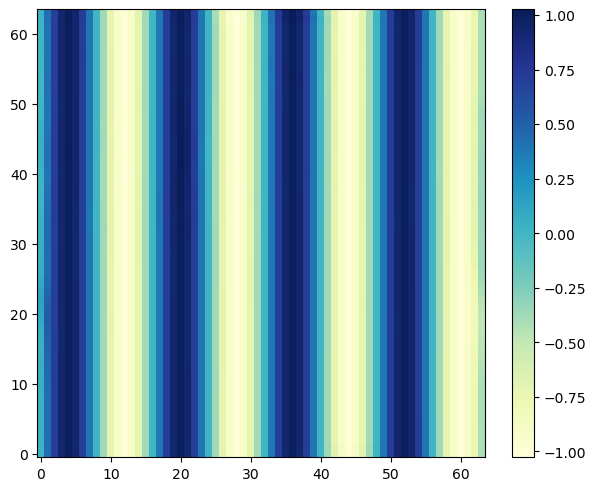

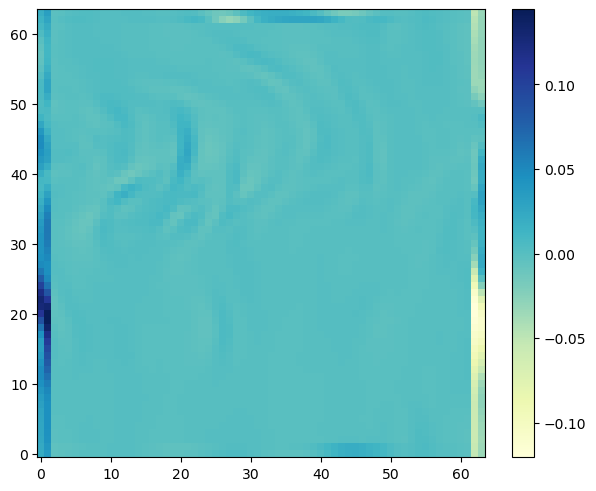

0.0008892289
0.5025996


In [19]:
plt.figure()
plt.imshow(mfield[0,100,10,:,:].T)
plt.colorbar()
plt.show()
plt.figure()
plt.imshow((mfield+forcing[...,[0]])[0,100,10,:,:].T)
plt.colorbar()
plt.show()
print(losses.momentum_loss(u_p[:200,...],datainfo,forcing=forcing))
print(losses.momentum_loss(u_p[:200,...],datainfo))

fr.flowrec.physics_and_derivatives.dissipation:261 [WARNING] Dissipation not normalised.


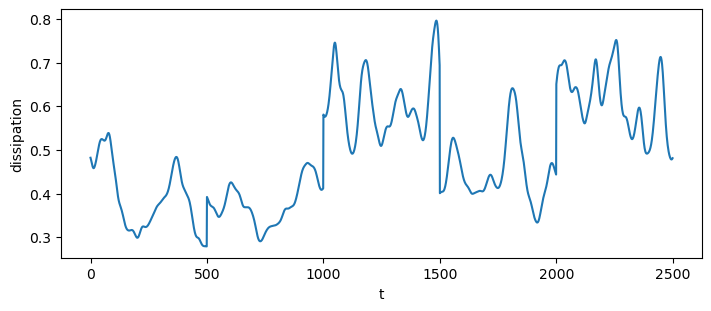

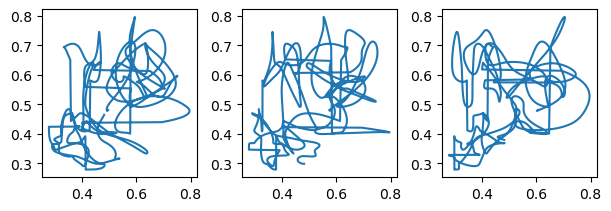

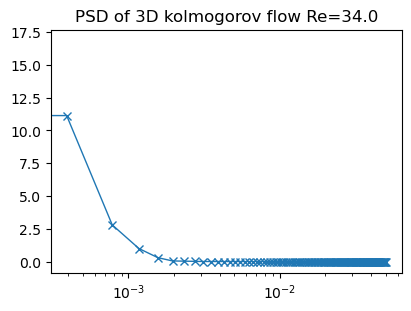

In [20]:
with jax.default_device(jax.devices('cpu')[0]):
    dissi = derivatives.dissipation(u_p[...,:-1], datainfo)
d_avg = np.mean(dissi.reshape(u_p.shape[0],-1), axis=1)
plt.figure(figsize=(7,3))
plt.plot(d_avg)
plt.xlabel('t')
plt.ylabel('dissipation')
_, axes = plt.subplots(1,3,figsize=(6,2))
axes[0].plot(d_avg[:-100],d_avg[100:])
axes[1].plot(d_avg[:-200],d_avg[200:])
axes[2].plot(d_avg[:-300],d_avg[300:])
plt.show()
pxx, freqs = mlab.psd(d_avg-np.mean(d_avg),Fs=datainfo.dt)
plt.figure(figsize=(4,3))
plt.title(f'PSD of 3D kolmogorov flow Re={re}')
plt.semilogx(freqs,pxx,linewidth=1,marker='x')
plt.show()

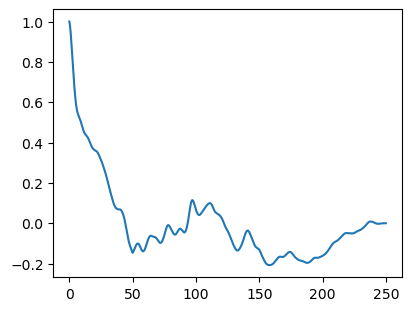

In [21]:
from flowrec.signal import autocorr
ac = autocorr(d_avg)
plt.figure(figsize=(4,3))
plt.plot(np.arange(len(ac))*datainfo.dt,ac)
plt.show()

# Sensors

In [22]:
z_plane = 32
inns_loc = np.s_[:,0,:,:,-1]
inns = u_p[inns_loc]
print(inns.shape)
y_loc = np.s_[:,:,:,[z_plane],:-1]
yref = u_p[y_loc]
print(yref.shape)

(2500, 64, 64)
(2500, 64, 64, 1, 3)


In [23]:
measured = np.empty_like(u_p[:10,...])
measured[inns_loc] = inns[:10,...]
measured[y_loc] = yref[:10,...]

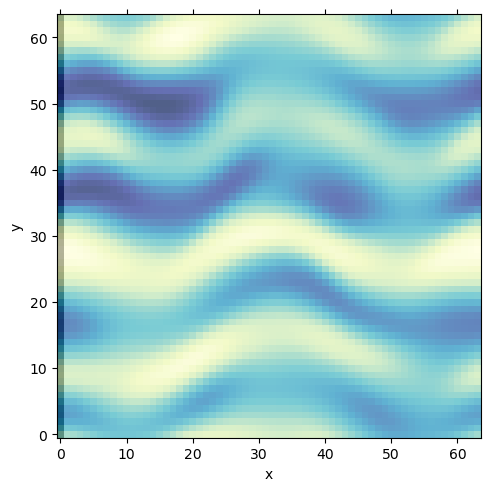

In [24]:
plt.figure()
plt.imshow(measured[0,:,:,z_plane,0].T, origin='lower')
plt.xlabel('x')
plt.ylabel('y')
plt.spy(measured[0,:,:,z_plane,-1].T,alpha=0.3, origin='lower')
plt.show()

Statistics

In [25]:
u_p.shape

(2500, 64, 64, 64, 4)

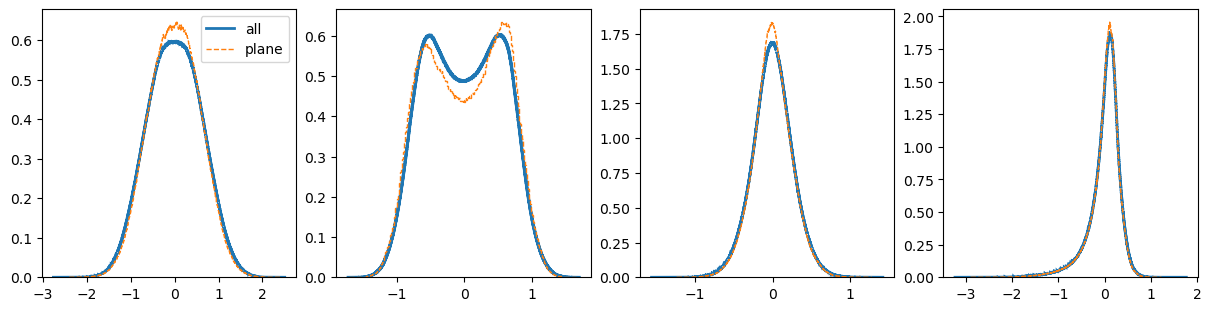

In [26]:
fig, axes = plt.subplots(1,4,figsize=(12,3))
for i,ax in enumerate(axes):
    counts,bins = np.histogram(u_p[...,i].flatten()-np.mean(u_p[...,i].flatten()), density=True, bins='auto')
    ax.stairs(counts,bins,label='all',linewidth=2)
    counts_plane,bins_plane = np.histogram(u_p[...,z_plane,i].flatten()-np.mean(u_p[...,z_plane,i].flatten()), density=True, bins='auto')
    ax.stairs(counts_plane,bins_plane,label='plane',linestyle='--')
axes[0].legend()

In [ ]:
fig,ax = plt.subplots(1,1)
spectrum_true, kbins = derivatives.get_tke(u_p-np.mean(u_p,axis=0), datainfo)
ax.loglog(kbins, spectrum_true)
k_nyquist = (2*np.pi / np.sqrt(2*(datainfo.dx**2))) / 2.
ax.grid()
ax.vlines(k_nyquist,10**-13, 10**8, 'k')
# axes.set_xlim([0.1, k_nyquist])
ax.legend()

# 1D to 2D

In [17]:
import flowrec.training_and_states as train
import optax
from train_config.train_options import optimizer as optimiser_options

In [18]:
key = jax.random.PRNGKey(1297)

In [19]:
from flowrec.models.feedforward import Model as FFMDL
from flowrec.models.feedforward import MLP

In [20]:
mdl1 = FFMDL(
    layers=[128,256,1024,yref[0,...].size],
    name = 'mdl1'
)

In [21]:
lr = 0.001
params1 = mdl1.init(key,inns[:10,:,z_plane])
scheduler1 = optimiser_options.get_scheduler('exponential_decay', lr)
optimiser1 = optax.adamw(learning_rate=scheduler1)
opt_state1 = optimiser1.init(params1)
state1 = train.TrainingState(params=params1, opt_state=opt_state1)
mdl1.apply(state1.params, key, inns[:10,:,z_plane]).shape
update1 = train.generate_update_fn(
    mdl1.apply,
    optimiser1,
    losses.loss_mse,
)
_l, _ = update1(state1, key, inns[:10,:,z_plane], yref[:10,...].reshape((10,-1)))
print(_l)

0.26411438


In [22]:
hist1 = []
best_l = jnp.inf

epoch 0, loss 0.2583860754966736
epoch 20, loss 0.06709625571966171
epoch 40, loss 0.04741451144218445
epoch 60, loss 0.03503512218594551
epoch 80, loss 0.02691631019115448
epoch 100, loss 0.02180321514606476
epoch 120, loss 0.01315323356539011
epoch 140, loss 0.010180076584219933
epoch 160, loss 0.0069245388731360435
epoch 180, loss 0.005356221459805965
epoch 200, loss 0.004544380120933056
epoch 220, loss 0.003202738706022501
epoch 240, loss 0.0026032542809844017
epoch 260, loss 0.0023886156268417835
epoch 280, loss 0.0018306090496480465
epoch 300, loss 0.0016397325089201331
epoch 320, loss 0.0014015301130712032
epoch 340, loss 0.002305224072188139
epoch 360, loss 0.0009682037634775043
epoch 380, loss 0.0008238719310611486
epoch 400, loss 0.0018464230233803391
epoch 420, loss 0.0007571059977635741
epoch 440, loss 0.0006924725603312254
epoch 460, loss 0.0006956346915103495
epoch 480, loss 0.0011630093213170767


Text(0, 0.5, 'loss mse')

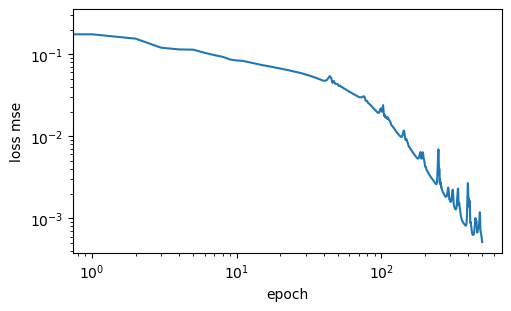

In [23]:
n_epochs = 500
batchsize = 250
for i in range(n_epochs):
    [key] = jax.random.split(key,1)
    l_epoch = []
    j = 0
    while (j+1)*batchsize <= u_p.shape[0] :
        _l, state1 = update1(state1, key, inns[j*batchsize:(j+1)*batchsize,:,z_plane], yref[j*batchsize:(j+1)*batchsize,...].reshape((batchsize,-1)))
        j += 1
        l_epoch.append(_l)
    l = np.mean(l_epoch)
    hist1.append(l)
    if i % 20 == 0:
        print(f'epoch {i}, loss {l}')
    if l < best_l:
        best_state1 = state1
        best_l = l
plt.figure(figsize=(5,3))
plt.loglog(hist1)
plt.xlabel('epoch')
plt.ylabel('loss mse')

In [24]:
pred_slice = mdl1.apply(best_state1.params, None, inns[:,:,z_plane]).reshape(yref.shape)

In [25]:
yref.shape

(500, 64, 64, 1, 3)

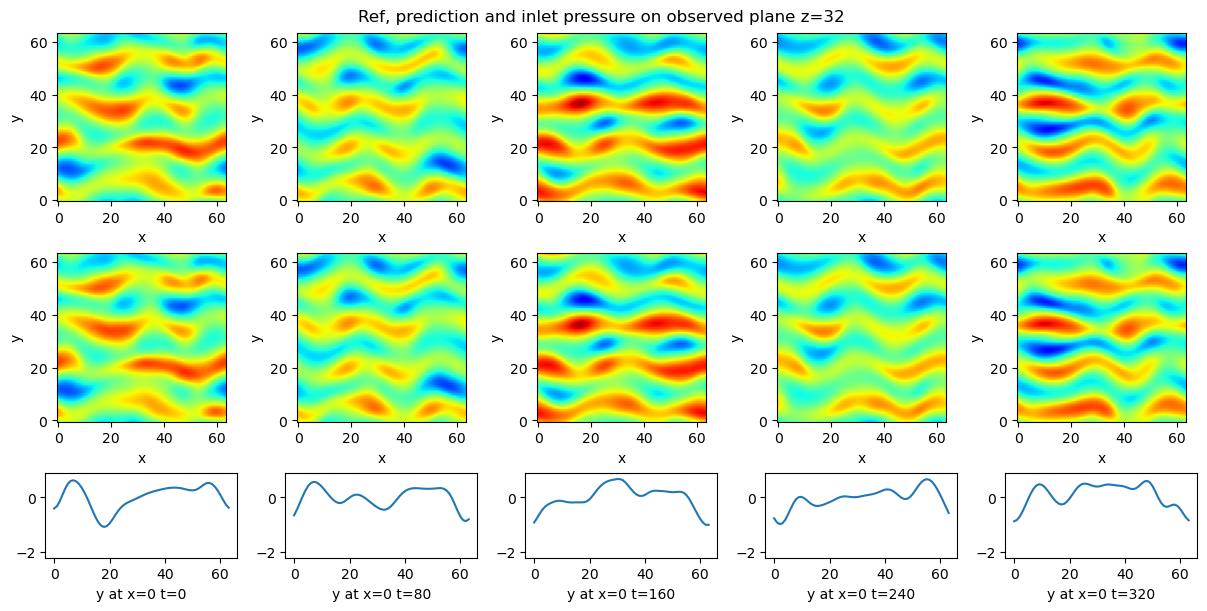

In [26]:
plt_step = 80
component = 0
vmin = yref[::plt_step,:,:,:,component].min()
vmax = yref[::plt_step,:,:,:,component].max()
ylims = [inns[:,:,z_plane].min(), inns[:,:,z_plane].max()]
fig, axes = plt.subplots(3,5,figsize=(12,6),height_ratios=(0.4,0.4,0.2))
fig.suptitle(f'Ref, prediction and inlet pressure on observed plane z={z_plane}')
for i in range(5):
    axes[0,i].imshow(yref[i*plt_step,:,:,0,component].T, vmin=vmin, vmax=vmax)
    axes[0,i].set(xlabel='x', ylabel='y')
    axes[1,i].imshow(pred_slice[i*plt_step,:,:,0,component].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x', ylabel='y')
    axes[2,i].plot(inns[i*plt_step,:,z_plane])
    axes[2,i].set(xlabel=f'y at x=0 t={i*plt_step}',ylim=ylims)
plt.show()

## test on volume

In [27]:
mdl1_pred_overz = jax.vmap(mdl1.predict, (None,2), 2)
predv1 = mdl1_pred_overz(best_state1.params, inns).reshape((*yref.shape,-1))
predv1 = np.einsum('txyiuz -> txyzu', predv1)
print(f'volume mse {losses.mse(predv1,u_p[...,:-1])}, measured plane {losses.mse(predv1[:,:,:,z_plane,:],yref[:,:,:,0,:])}')
print(f'volume relative loss {losses.relative_error(predv1,u_p[...,:-1])}, measured plane {losses.relative_error(predv1[:,:,:,z_plane,:],yref[:,:,:,0,:])}')
for r in [10,20,30]:
    print(f'volume relative loss for planes z_plane+-{r} {losses.relative_error(predv1[...,z_plane-r:z_plane+r,:],u_p[...,z_plane-r:z_plane+r,:-1])}')

volume mse 0.19369293749332428, measured plane 0.00046580893103964627
volume relative loss 0.8498690724372864, measured plane 0.04135291278362274
volume relative loss for planes z_plane+-10 0.6072885990142822
volume relative loss for planes z_plane+-20 0.787594735622406
volume relative loss for planes z_plane+-30 0.8423147201538086


In [ ]:
plt_z = [10,25,30,34,42,60]
plt_t = 100
component = 0
vmin = u_p[::plt_step,:,:,plt_z,component].min()
vmax = u_p[::plt_step,:,:,plt_z,component].max()
ylims = [inns[:,:,plt_z].min(), inns[:,:,plt_z].max()]
fig, axes = plt.subplots(3,5,figsize=(12,6),height_ratios=(0.4,0.4,0.2))
fig.suptitle('Ref, prediction and inlet pressure')
for i in range(5):
    axes[0,i].imshow(u_p[plt_t,:,:,plt_z[i],component].T, vmin=vmin, vmax=vmax)
    axes[0,i].set(xlabel='x', ylabel='y')
    axes[1,i].imshow(predv1[plt_t,:,:,plt_z[i],component].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x', ylabel='y')
    axes[2,i].plot(inns[plt_t,:,plt_z[i]])
    axes[2,i].set(xlabel=f'y at x=0 t={plt_t}, z={plt_z[i]}',ylim=ylims)
plt.show()

In [ ]:
plt_t = 150
fig,axes = plt.subplots(2,3,sharex=True,sharey=True,figsize=(5,2.5))
fig.suptitle(f'At z={z_plane}, t={plt_t}')
for i in range(3):
    imref = axes[0,i].imshow(u_p[plt_t,:,:,z_plane,i].T)
    vmin,vmax = imref.get_clim()
    axes[1,i].imshow(predv1[plt_t,:,:,z_plane,i].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')

fig,axes = plt.subplots(2,3,sharex=True,sharey=True,figsize=(5,2.5))
fig.suptitle(f'At x={0}, t={plt_t}')
for i in range(3):
    imref = axes[0,i].imshow(u_p[plt_t,0,:,:,i])
    vmin,vmax = imref.get_clim()
    axes[1,i].imshow(predv1[plt_t,0,:,:,i], vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='z')
axes[0,0].set_ylabel('z')
axes[1,0].set_ylabel('y')

fig,axes = plt.subplots(2,3,sharex=True,sharey=True,figsize=(5,2.5))
fig.suptitle(f'At z={z_plane}, time average')
for i in range(3):
    imref = axes[0,i].imshow(np.mean(u_p[:,:,:,z_plane,i],axis=0).T)
    vmin,vmax = imref.get_clim()
    axes[1,i].imshow(np.mean(predv1[:,:,:,z_plane,i],axis=0).T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')

fig,axes = plt.subplots(2,3,sharex=True,sharey=True,figsize=(5,2.5))
fig.suptitle(f'At x={0}, time average')
for i in range(3):
    imref = axes[0,i].imshow(np.mean(u_p[:,0,:,:,i],axis=0))
    vmin,vmax = imref.get_clim()
    axes[1,i].imshow(np.mean(predv1[:,0,:,:,i],axis=0), vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='z')
axes[0,0].set_ylabel('z')
axes[1,0].set_ylabel('y')
plt.show()

### Statistics over volume

In [56]:
def plot_stats(pred, true):
    fig1 = plt.figure(figsize=(4,2))
    g = ImageGrid(fig1, 111, (1,2), cbar_mode='single')
    imref = g.axes_all[0].imshow(np.mean(true, axis=(0,3))[:,:,0].T)
    vmin, vmax = imref.get_clim()
    impred = g.axes_all[1].imshow(np.mean(pred, axis=(0,3))[:,:,0].T, vmin=vmin, vmax=vmax)
    g.cbar_axes[0].colorbar(imref)
    fig1.suptitle('ref and reconstructed averaged over z & time')

    fig2, axes = plt.subplots(1,4,figsize=(8,2))
    for i,ax in enumerate(axes[:3]):
        counts_true,bins_true = np.histogram(true[...,i].flatten()-np.mean(true[...,i].flatten()), density=True, bins='auto')
        ax.stairs(counts_true,bins_true,label='true',linewidth=3, color='#808080',alpha=0.5)
        counts,bins= np.histogram(pred[...,i].flatten()-np.mean(pred[...,i].flatten()), density=True, bins='auto')
        ax.stairs(counts,bins,label='recons')
    spectrum_true, kbins = derivatives.get_tke(true-np.mean(true,axis=0), datainfo)
    spectrum, _ = derivatives.get_tke(pred-np.mean(pred,axis=0), datainfo)
    axes[3].loglog(kbins,spectrum_true,label='true',linewidth=3, color='#808080',alpha=0.5)
    axes[3].loglog(kbins,spectrum,label='recons')
    axes[3].grid(which='both',axis='x')
    axes[3].legend()
    
    return (fig1,g), (fig2,axes)

def print_losses(pred, true):
    with jax.default_device(jax.devices('cpu')[0]):
        _momfield = [losses.momentum_residual_field(pred[i*80:(i+1)*80,...],datainfo,forcing=forcing) for i in range(10)]
        _momfield = jnp.concatenate(_momfield, axis=0)
        _momfield_ref = [losses.momentum_residual_field(true[i*80:(i+1)*80,...],datainfo,forcing=forcing) for i in range(10)]
        _momfield_ref = jnp.concatenate(_momfield_ref, axis=0)
        l_momentum = losses.mse(_momfield)
        l_momentum_ref = losses.mse(_momfield_ref)
    l_div = losses.divergence(pred[...,:-1],datainfo)
    l_div_ref = losses.divergence(true[...,:-1],datainfo)
    l_rel = losses.relative_error(pred, true)
    l_mse_slice = losses.mse(pred[...,z_plane,:-1],true[...,z_plane,:-1])

    print(f'ref momentum loss: {l_momentum_ref:.5f}, ref divergence loss: {l_div_ref:.5f}')
    print(f'pred momentum loss: {l_momentum:.5f}, pred divergence loss: {l_div:.5f}')
    print(f'Relative error of the domain {l_rel*100:.3f}%')
    print(f'Relative error of the domain close to the measured plane from z=20 to z=50 {100*losses.relative_error(pred[...,20:50,:], true[...,20:50,:]):.5f}%')
    print(f'MSE of the domain close to the measured plane from z=20 to z=50 {100*losses.mse(pred[...,20:50,:], true[...,20:50,:]):.5f}')
    print(f'MSE of the measured plane {l_mse_slice:5f}')

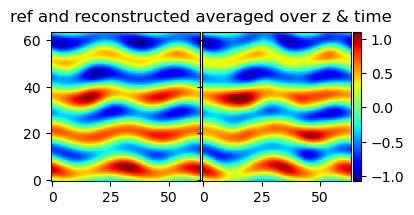

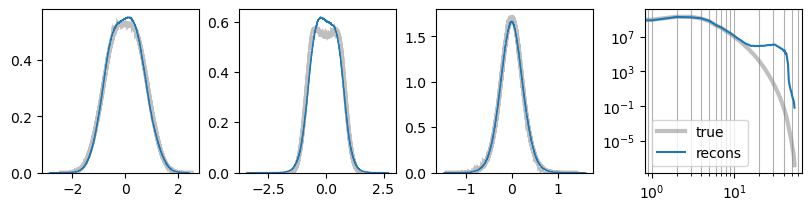

In [57]:
(fig1,_), (fig2,_) = plot_stats(predv1, u_p[...,:-1])
plt.show()

# Test new model

In [1]:
import haiku as hk
import jax

In [2]:
from flowrec.models.cnn import MLPWithCNN,MLP

In [ ]:
from flowrec.models.slice3d import Model as ModelSlice3D
mdl_test = ModelSlice3D(
    pretrained_model = MLP, # model
    newvar_model = MLPWithCNN,
    pretrained_config = {
        'output_sizes':[128,256,1024,64*64*3],
        'name': 'mdl1',
        'w_init':hk.initializers.VarianceScaling(1.0),
        'activation':'tanh'
    }, 
    # newvar_config = {
    #     'output_sizes':[256,1024,int(yref[0,...].size/3)],
    #     'name': 'mdl2',
    #     'w_init':hk.initializers.VarianceScaling(1.0),
    #     'activation':jax.nn.tanh
    # },
    newvar_config = {
        'mlp_layers': [256,1024,4096],
        'output_shape': (64,64,1), 
        'cnn_channels': [2,2,1],
        'cnn_filters': [(3,3)]
    },
    reduce_layers = [10,100], #int for linear
    map_axis = (2,3), # map which input axis to which output axis  
)
key = jax.random.PRNGKey(100)
test_params = mdl_test.init(key, jax.random.uniform(key,(10,60,5)))
# print(list(test_params))
jit_apply = jax.jit(mdl_test.apply, static_argnames=['training'])
# test_out = jit_apply(test_params, key, inns[:10, :, 30:32], training=False)
# print(test_out.shape)

<class 'jaxlib.xla_extension.PjitFunction'>
(10, 100)
(10, 64, 64, 1)


# Add pressure

In [31]:
best_state1.params.keys()

dict_keys(['mdl1/~/linear_0', 'mdl1/~/linear_1', 'mdl1/~/linear_2', 'mdl1/~/linear_3'])

In [32]:
import haiku as hk

In [ ]:
def forward2(p):
    _mlp = MLP(
        [128,256,1024,yref[0,...].size],
        name = 'mdl1',
        w_init=hk.initializers.VarianceScaling(1.0),
        activation=jax.nn.tanh
    )
    imagesize = yref.shape[1:-2]
    linear_reduce = [hk.Linear(n, name=f'reduce{i}') for i,n in enumerate([512,128])]
    linear_p = [hk.Linear(n, name=f'p{i}') for i,n in enumerate([128,512,1024,int(yref[0,...].size/3)])]
    def over_z(p1):
        u = _mlp(p1,TRAINING=True)
        u_reduce = jnp.copy(u)
        for l in linear_reduce:
            u_reduce = jax.nn.tanh(u_reduce)
            u_reduce = l(u_reduce)
        outp = linear_p[0](p1)
        outp = outp + u_reduce
        for l in linear_p[1:]:
            outp = jax.nn.tanh(outp)
            outp = l(outp)
        outp = outp.reshape((-1,)+imagesize+(1,))
        return jnp.concatenate((u.reshape((-1,)+imagesize+(3,)), outp), axis=-1) # (txy1u)
    out = jax.vmap(over_z, 2, 3)(p)
    return out
mdl2 = hk.transform(forward2)
params2 = mdl2.init(key, inns[:10,:,30:35])
print(list(params2))
print(mdl2.apply(params2, None, inns[:10,:,30:35]).shape)

In [85]:
import logging
logging.getLogger('fr.flowrec.models.slice3d').setLevel(logging.DEBUG)
# mdl2 = mdl_test
# params2 = test_params
params2 = hk.data_structures.merge(state2.params, params2_non_trainable)
print(list(params2))
# mdl2.load_pretrained_weights(params2,best_state1.params)
params2_non_trainable, params2_trainable = mdl2.freeze_layers(params2, ('mdl1/~/linear_0', 'mdl1/~/linear_1', 'mdl1/~/linear_2','ffcnn/~/mlp/~/linear_0', 'ffcnn/~/mlp/~/linear_1'))
mdl2.set_nontrainable(params2_non_trainable)
print(list(params2_non_trainable))
print(list(params2_trainable))
print(jax.tree_map(lambda x: print(x.shape),params2_trainable))

['slice3d/~/ffcnn/~/convolve_0', 'slice3d/~/ffcnn/~/convolve_1', 'slice3d/~/ffcnn/~/convolve_2', 'slice3d/~/ffcnn/~/mlp/~/linear_2', 'slice3d/~/mdl1/~/linear_3', 'slice3d/~/merge', 'slice3d/~/reduce0', 'slice3d/~/reduce1', 'slice3d/~/ffcnn/~/mlp/~/linear_0', 'slice3d/~/ffcnn/~/mlp/~/linear_1', 'slice3d/~/mdl1/~/linear_0', 'slice3d/~/mdl1/~/linear_1', 'slice3d/~/mdl1/~/linear_2']
['slice3d/~/ffcnn/~/mlp/~/linear_0', 'slice3d/~/ffcnn/~/mlp/~/linear_1', 'slice3d/~/mdl1/~/linear_0', 'slice3d/~/mdl1/~/linear_1', 'slice3d/~/mdl1/~/linear_2']
8
(2,)
(3, 3, 1, 2)
(2,)
(3, 3, 2, 2)
(1,)
(3, 3, 2, 1)
(4096,)
(1024, 4096)
(12288,)
(1024, 12288)
(100,)
(64, 100)
(10,)
(12288, 10)
(100,)
(10, 100)
{'slice3d/~/ffcnn/~/convolve_0': {'b': None, 'w': None}, 'slice3d/~/ffcnn/~/convolve_1': {'b': None, 'w': None}, 'slice3d/~/ffcnn/~/convolve_2': {'b': None, 'w': None}, 'slice3d/~/ffcnn/~/mlp/~/linear_2': {'b': None, 'w': None}, 'slice3d/~/mdl1/~/linear_3': {'b': None, 'w': None}, 'slice3d/~/merge': {'b':

/home/ym917/Codes/FlowReconstructionFromExperiment/flowrec/models/slice3d.py:149: UserWarning: Overriding the old non_trainable_params.
  warnings.warn('Overriding the old non_trainable_params.')


In [42]:
## split weights
for k, layer in best_state1.params.items():
    if k in params2.keys():
        print(k)
        params2[k].update(layer)
        # print(k, layer.keys())
# print(np.allclose(params2['mdl1/~/linear_3']['w'], best_state1.params['mdl1/~/linear_3']['w']))
params2_non_trainable, params2_trainable = hk.data_structures.partition(
    lambda module_name, name, value: module_name in ['mdl1/~/linear_0', 'mdl1/~/linear_1', 'mdl1/~/linear_2','mdl1/~/linear_3'],
    params2
)
print(list(params2_trainable))
print(list(params2_non_trainable))
# print(jax.tree_map(lambda x: print(x.shape),params2_trainable))

['slice3d/~/ffcnn/~/convolve_0', 'slice3d/~/ffcnn/~/convolve_1', 'slice3d/~/ffcnn/~/convolve_2', 'slice3d/~/ffcnn/~/mlp/~/linear_0', 'slice3d/~/ffcnn/~/mlp/~/linear_1', 'slice3d/~/ffcnn/~/mlp/~/linear_2', 'slice3d/~/mdl1/~/linear_0', 'slice3d/~/mdl1/~/linear_1', 'slice3d/~/mdl1/~/linear_2', 'slice3d/~/mdl1/~/linear_3', 'slice3d/~/merge', 'slice3d/~/reduce0', 'slice3d/~/reduce1']
[]


In [84]:
lr = 0.001
scheduler2 = optimiser_options.get_scheduler('exponential_decay', lr)
optimiser2 = optax.adamw(learning_rate=scheduler2)
opt_state2 = optimiser2.init(params2_trainable)
state2 = train.TrainingState(params=params2_trainable, opt_state=opt_state2)
# print(mdl2.apply(
#     hk.data_structures.merge(state2.params,params2_non_trainable),
#     key, 
#     inns[:10,...]
# ).shape)
print(mdl2.apply_trainable(
    state2.params,
    key, 
    inns[:10,...]
).shape)

(10, 64, 64, 64, 4)


In [67]:
def loss2(apply_fn, trainable, rng, inns, yall, non_trainable, forcing, z_plane, w_ld):
    params = hk.data_structures.merge(trainable, non_trainable)
    pred = apply_fn(params, rng, inns)
    print(pred.shape)
    ld = losses.mse(pred[:,:,:,z_plane,:-1], yall[:,:,:,z_plane,:-1]) + losses.mse(pred[inns_loc],yall[inns_loc]) # data loss, velocities on the plane and pressure at inlet
    pred_new = pred.at[:,:,:,z_plane,:-1].set(yall[:,:,:,z_plane,:-1])
    pred_new = pred_new.at[inns_loc].set(yall[inns_loc])
    # unnormalise before taking physics loss
    ldiv = losses.divergence(pred_new[...,:-1], datainfo)
    lmom = losses.momentum_loss(pred_new, datainfo, forcing=forcing)
    # Poisson equation for incompressible flow
    # lp = 
    
    return w_ld*ld + ldiv + lmom, {'plane': ld, 'div':ldiv, 'momentum':lmom}

In [77]:
## z_plane must change if not training with all slices
z1,z2 = 20,50
update2 = train.generate_update_fn(
    mdl2.apply,
    optimiser2,
    loss2,
    kwargs_loss={'non_trainable': params2_non_trainable, 'forcing': forcing[...,[0]], 'z_plane':z_plane-z1, 'w_ld':50},
    kwargs_value_and_grad={'has_aux':True}
)
%timeit l,_ = update2(state2, key, inns[:20,...,z1:z2], u_p[:20,...,z1:z2,:])
print(l)

(20, 64, 64, 30, 4)
113 ms ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(Array(20.619474, dtype=float32), {'div': Array(0.44315597, dtype=float32), 'momentum': Array(8.256986, dtype=float32), 'plane': Array(0.23838665, dtype=float32)})


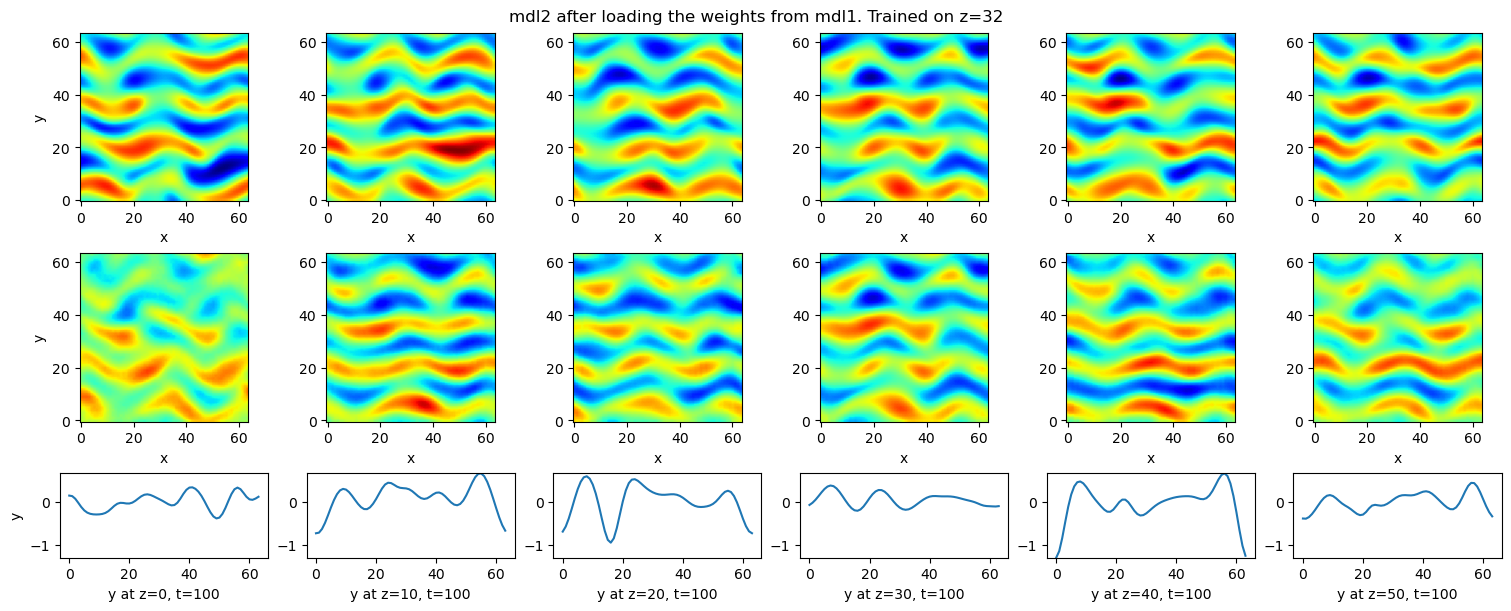

In [78]:
predv2 = mdl2.apply(params2, None, inns[:200,...])
plt_zgap = 10
plt_t = 100
vmin = u_p[plt_t,...,::plt_zgap,0].min()
vmax = u_p[plt_t,...,::plt_zgap,0].max()
fig,axes = plt.subplots(3,6,figsize=(15,6),height_ratios=(0.4,0.4,0.2))
fig.suptitle(f'mdl2 after loading the weights from mdl1. Trained on z={z_plane}')
for i in range(6):
    axes[2,i].plot(inns[plt_t,:,i*plt_zgap])
    axes[2,i].set(xlabel=f'y at z={i*plt_zgap}, t={plt_t}', ylim=[inns[plt_t,:,::plt_zgap].min(), inns[plt_t,:,::plt_zgap].max()])
    axes[0,i].imshow(u_p[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[0,i].set(xlabel='x')
    axes[1,i].imshow(predv2[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')
axes[2,0].set_ylabel('y')
plt.show()

In [70]:
hist2 = {'loss':[], 'plane':[], 'div':[], 'momentum':[]}
best_l = np.inf

(500, 64, 64, 30, 4)
epoch 0,  loss: 0.95285 plane: 0.00407 div: 0.14970 momentum: 0.59943
epoch 20,  loss: 3.26461 plane: 0.00929 div: 0.50531 momentum: 2.29463
epoch 40,  loss: 1.49822 plane: 0.00594 div: 0.23778 momentum: 0.96367
epoch 60,  loss: 0.99400 plane: 0.00450 div: 0.15440 momentum: 0.61440
epoch 80,  loss: 0.91959 plane: 0.00411 div: 0.14507 momentum: 0.56900
epoch 100,  loss: 0.90085 plane: 0.00395 div: 0.14320 momentum: 0.55993
epoch 120,  loss: 0.88920 plane: 0.00384 div: 0.14239 momentum: 0.55459
epoch 140,  loss: 0.87924 plane: 0.00375 div: 0.14167 momentum: 0.54989
epoch 160,  loss: 0.86982 plane: 0.00367 div: 0.14093 momentum: 0.54519
epoch 180,  loss: 0.86071 plane: 0.00360 div: 0.14016 momentum: 0.54045
epoch 200,  loss: 0.85187 plane: 0.00354 div: 0.13938 momentum: 0.53568
epoch 220,  loss: 0.84325 plane: 0.00348 div: 0.13858 momentum: 0.53091
epoch 240,  loss: 0.83486 plane: 0.00342 div: 0.13777 momentum: 0.52615
epoch 260,  loss: 0.82666 plane: 0.00337 div: 0.1

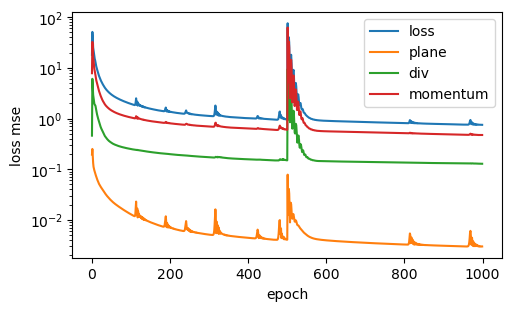

In [79]:
n_epochs = 500
batch = 500
for i in range(n_epochs):
    [key] = jax.random.split(key,1)
    l_epoch = {'loss':[], 'div':[], 'plane':[], 'momentum':[]}
    j = 0
    while (j+1)*batch <=  u_p.shape[0]:
        (_l, _l_components), state2 = update2(state2, key, inns[j*batch:(j+1)*batch,...,z1:z2], u_p[j*batch:(j+1)*batch,...,z1:z2,:])
        j += 1
        l_epoch['loss'].append(float(_l))
        for k,a in _l_components.items():
            l_epoch[k].append(float(a))
    for k,a in l_epoch.items():
        hist2[k].append(np.mean(a))
    if i % 20 == 0:
        print(f'epoch {i}, ', " ".join(f"{k}: {a[-1]:.5f}" for k, a in hist2.items()))
    if hist2['loss'][-1] < best_l:
        best_state2 = state2
        best_l = hist2['loss'][-1]
plt.figure(figsize=(5,3))
for k in hist2.keys():
    plt.semilogy(hist2[k], label=k)
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss mse')
plt.show()

In [72]:
predv2 = mdl2.apply(hk.data_structures.merge(best_state2.params, params2_non_trainable), None, inns[:200,...])

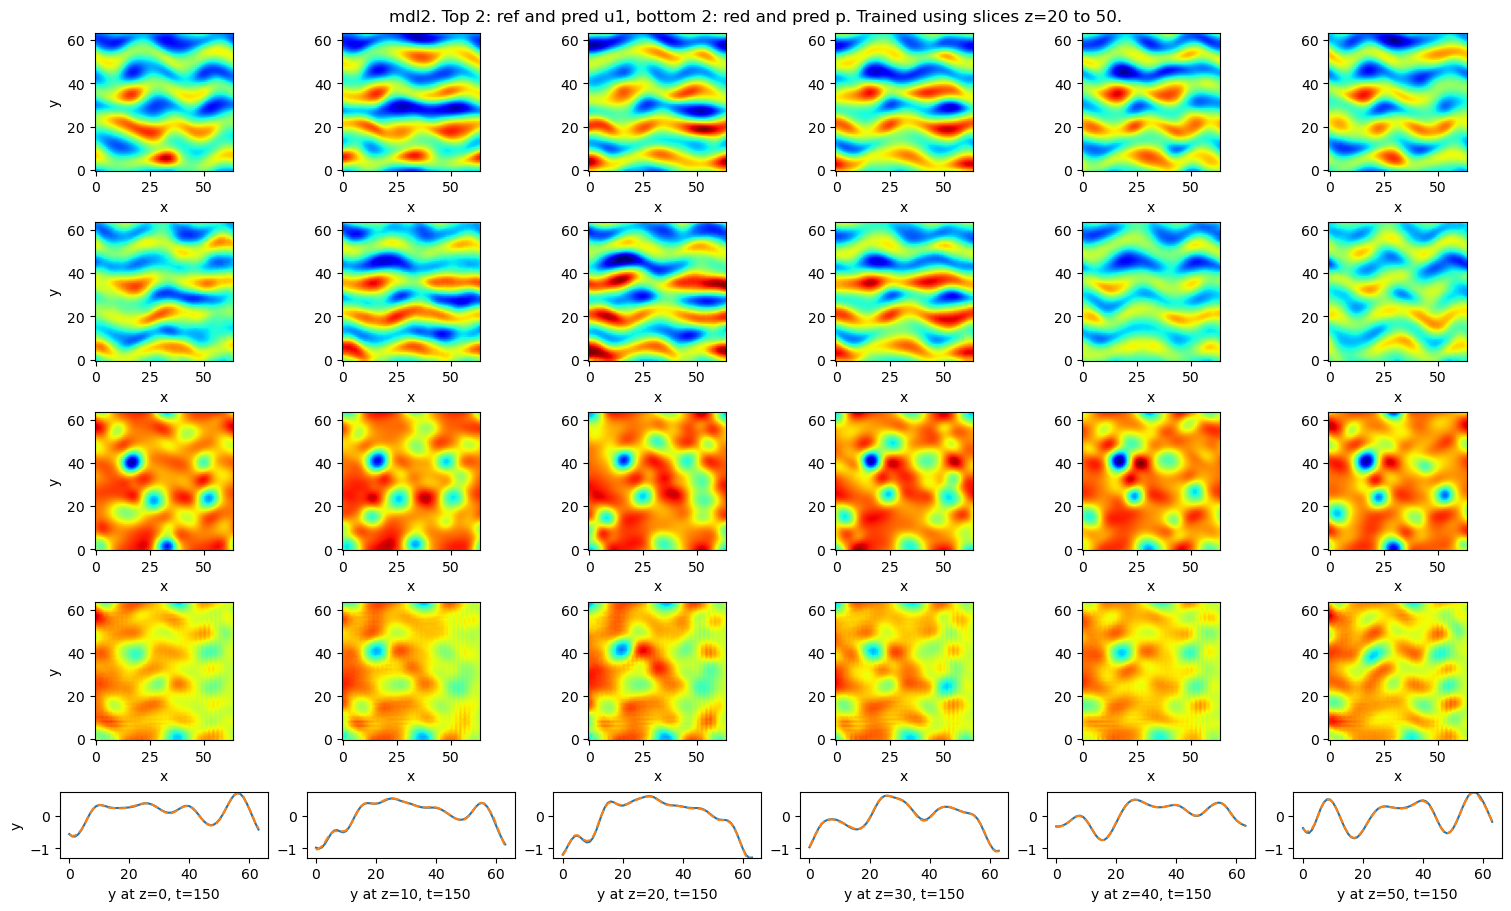

In [73]:
plt_zgap = 10
plt_t = 150
vmin = u_p[plt_t,...,::plt_zgap,0].min()
vmax = u_p[plt_t,...,::plt_zgap,0].max()
vminp = u_p[plt_t,...,::plt_zgap,-1].min()
vmaxp = u_p[plt_t,...,::plt_zgap,-1].max()
fig,axes = plt.subplots(5,6,figsize=(15,9),height_ratios=(0.21,0.21,0.21,0.21,0.1))
fig.suptitle(f'mdl2. Top 2: ref and pred u1, bottom 2: red and pred p. Trained using slices z={z1} to {z2}.')
for i in range(6):
    axes[4,i].plot(inns[plt_t,:,i*plt_zgap])
    axes[4,i].plot(predv2[inns_loc][plt_t,:,i*plt_zgap],'--')
    axes[4,i].set(xlabel=f'y at z={i*plt_zgap}, t={plt_t}', ylim=[inns[plt_t,:,::plt_zgap].min(), inns[plt_t,:,::plt_zgap].max()])
    axes[0,i].imshow(u_p[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[0,i].set(xlabel='x')
    axes[1,i].imshow(predv2[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
    axes[2,i].imshow(u_p[plt_t,:,:,i*plt_zgap,-1].T, vmin=vminp, vmax=vmaxp)
    axes[2,i].set(xlabel='x')
    axes[3,i].imshow(predv2[plt_t,:,:,i*plt_zgap,-1].T, vmin=vminp, vmax=vmaxp)
    axes[3,i].set(xlabel='x')
axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')
axes[2,0].set_ylabel('y')
axes[3,0].set_ylabel('y')
axes[4,0].set_ylabel('y')
plt.show()

/home/ym917/miniconda3/envs/fr/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


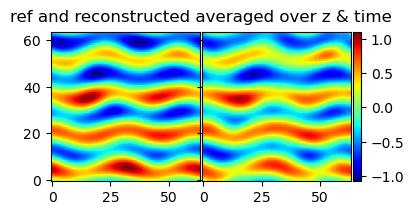

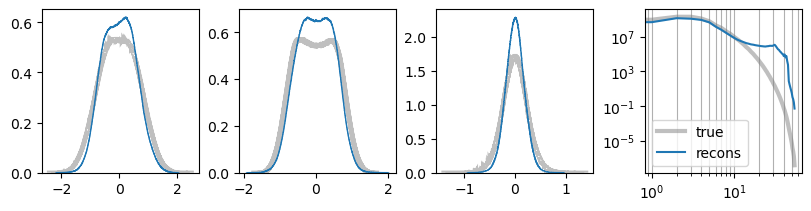

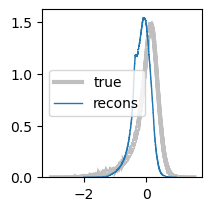

In [74]:
plot_stats(predv2, u_p[...,:-1])
plt.figure(figsize=(2,2))
counts_true,bins_true = np.histogram(u_p[...,-1].flatten()-np.mean(u_p[...,0].flatten()), density=True, bins='auto')
plt.stairs(counts_true,bins_true,label='true',linewidth=3, color='#808080',alpha=0.5)
counts_pred,bins_pred = np.histogram(predv2[...,-1].flatten()-np.mean(predv2[...,0].flatten()), density=True, bins='auto')
plt.stairs(counts_pred,bins_pred,label='recons')
plt.legend()
plt.show()

## fine tune last layers

In [ ]:
params2v2_trainable, params2v2_non_trainable = hk.data_structures.partition(
    lambda module_name, name, value: module_name in ['mdl1/~/linear_1','mdl1/~/linear_2','mdl1/~/linear_3','p3','p2','reduce1','reduce0'],
    hk.data_structures.merge(best_state2.params, params2_non_trainable)
)
print(list(params2v2_trainable))
print(list(params2v2_non_trainable))

In [ ]:
params2v2_non_trainable, params2v2_trainable = hk.data_structures.partition(
    lambda module_name, name, value: module_name in ['mdl1/~/linear_0','mdl1/~/linear_1'],
    params2
)
print(list(params2v2_trainable))
print(list(params2v2_non_trainable))

In [ ]:
for k,v in hk.data_structures.merge(params2v2_trainable, params2v2_non_trainable).items():
    print(np.allclose(v['w'],hk.data_structures.merge(best_state2.params, params2_non_trainable)[k]['w']))

In [ ]:
predv2_2pretrain = mdl2.apply(hk.data_structures.merge(params2v2_trainable, params2v2_non_trainable), None, inns[:200,...])
plt_zgap = 12
plt_t = 150
vmin = u_p[plt_t,...,::plt_zgap,0].min()
vmax = u_p[plt_t,...,::plt_zgap,0].max()
vminp = u_p[plt_t,...,::plt_zgap,-1].min()
vmaxp = u_p[plt_t,...,::plt_zgap,-1].max()
fig,axes = plt.subplots(5,6,figsize=(15,9),height_ratios=(0.21,0.21,0.21,0.21,0.1))
fig.suptitle(f'mdl2 pre-training. Top 2: ref and pred u1, bottom 2: red and pred p. Trained on z={z1} to {z2}.')
for i in range(6):
    axes[4,i].plot(inns[plt_t,:,i*plt_zgap])
    axes[4,i].plot(predv2_2pretrain[inns_loc][plt_t,:,i*plt_zgap],'--')
    axes[4,i].set(xlabel=f'y at z={i*plt_zgap}, t={plt_t}', ylim=[inns[plt_t,:,::plt_zgap].min(), inns[plt_t,:,::plt_zgap].max()])
    axes[0,i].imshow(u_p[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[0,i].set(xlabel='x')
    axes[1,i].imshow(predv2_2pretrain[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
    axes[2,i].imshow(u_p[plt_t,:,:,i*plt_zgap,-1].T, vmin=vminp, vmax=vmaxp)
    axes[2,i].set(xlabel='x')
    axes[3,i].imshow(predv2_2pretrain[plt_t,:,:,i*plt_zgap,-1].T, vmin=vminp, vmax=vmaxp)
    axes[3,i].set(xlabel='x')
axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')
axes[2,0].set_ylabel('y')
axes[3,0].set_ylabel('y')
axes[4,0].set_ylabel('y')
plt.show()

In [ ]:
lr = 0.001
scheduler2v2 = optimiser_options.get_scheduler('cyclic_decay_default', lr)
optimiser2v2 = optax.adamw(learning_rate=scheduler2v2)
opt_state2v2 = optimiser2v2.init(params2v2_trainable)

In [86]:
for k,v in best_state1.opt_state[0].mu.items():
    if k in opt_state2v2[0].mu.keys():
        opt_state2v2[0].mu.update({k: v})
for k,v in best_state1.opt_state[0].nu.items():
    if k in opt_state2v2[0].nu.keys():
        opt_state2v2[0].nu.update({k: v})
        print(k)

mdl1/~/linear_0
mdl1/~/linear_1
mdl1/~/linear_2
mdl1/~/linear_3


In [ ]:
state2v2 = train.TrainingState(params=params2v2_trainable, opt_state=opt_state2v2)
print(mdl2.apply(
    hk.data_structures.merge(state2v2.params,params2v2_non_trainable),
    key, 
    inns[:10,...]
).shape)

In [ ]:
## z_plane must change if not training with all slices
z1,z2 = 20,50
update2v2 = train.generate_update_fn(
    mdl2.apply,
    optimiser2v2,
    loss2,
    kwargs_loss={'non_trainable': params2v2_non_trainable, 'forcing': forcing[...,[0]], 'z_plane':z_plane-z1, 'w_ld':80},
    kwargs_value_and_grad={'has_aux':True}
)
l,_ = update2v2(state2v2, key, inns[:20,...,z1:z2], u_p[:20,...,z1:z2,:])
print(l)

In [ ]:
hist2v2 = {'loss':[], 'plane':[], 'div':[], 'momentum':[]}
best_l = np.inf

In [ ]:
n_epochs = 1000
batch = 500
for i in range(n_epochs):
    [key] = jax.random.split(key,1)
    l_epoch = {'loss':[], 'div':[], 'plane':[], 'momentum':[]}
    j = 0
    while (j+1)*batch <=  u_p.shape[0]:
        (_l, _l_components), state2v2 = update2v2(state2v2, key, inns[j*batch:(j+1)*batch,...,z1:z2], u_p[j*batch:(j+1)*batch,...,z1:z2,:])
        j += 1
        l_epoch['loss'].append(float(_l))
        for k,a in _l_components.items():
            l_epoch[k].append(float(a))
    for k,a in l_epoch.items():
        hist2v2[k].append(np.mean(a))
    if i % 20 == 0:
        print(f'epoch {i}, ', " ".join(f"{k}: {a[-1]:.5f}" for k, a in hist2v2.items()))
    if hist2v2['loss'][-1] < best_l:
        best_state2v2 = state2v2
        best_l = hist2v2['loss'][-1]
plt.figure(figsize=(5,3))
for k in hist2v2.keys():
    plt.semilogy(hist2v2[k], label=k)
plt.legend() 
plt.xlabel('epoch')
plt.ylabel('loss mse')
plt.show()

In [ ]:
predv2_2 = [mdl2.apply(hk.data_structures.merge(best_state2v2.params, params2v2_non_trainable), None, inns[i*200:(i+1)*200,...]) for i in range(4)]
predv2_2 = np.concatenate(predv2_2, axis=0)

In [ ]:
# plt_zgap = 10
# plt_t = 150
vmin = u_p[plt_t,...,::plt_zgap,0].min()
vmax = u_p[plt_t,...,::plt_zgap,0].max()
vminp = u_p[plt_t,...,::plt_zgap,-1].min()
vmaxp = u_p[plt_t,...,::plt_zgap,-1].max()
fig,axes = plt.subplots(7,6,figsize=(15,15),height_ratios=(0.15,0.15,0.15,0.15,0.15,0.15,0.1))
fig.suptitle(f'mdl2v2 fine tuning. Top 2: ref and pred u1, bottom 2: red and pred p. Trained on z={z1} to {z2}.')
for i in range(6):
    axes[6,i].plot(inns[plt_t,:,i*plt_zgap])
    axes[6,i].plot(predv2_2[inns_loc][plt_t,:,i*plt_zgap],'--')
    axes[6,i].set(xlabel=f'y at z={i*plt_zgap}, t={plt_t}', ylim=[inns[plt_t,:,::plt_zgap].min(), inns[plt_t,:,::plt_zgap].max()])
    
    axes[0,i].imshow(u_p[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[0,i].set(xlabel='x')
    axes[1,i].imshow(predv2_2[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
    axes[2,i].imshow(np.abs(u_p[plt_t,:,:,i*plt_zgap,0].T-predv2_2[plt_t,:,:,i*plt_zgap,0].T))
    axes[2,i].set(xlabel='x')

    axes[3,i].imshow(u_p[plt_t,:,:,i*plt_zgap,-1].T, vmin=vminp, vmax=vmaxp)
    axes[3,i].set(xlabel='x')
    axes[4,i].imshow(predv2_2[plt_t,:,:,i*plt_zgap,-1].T, vmin=vminp, vmax=vmaxp)
    axes[4,i].set(xlabel='x')
    axes[5,i].imshow(np.abs(u_p[plt_t,:,:,i*plt_zgap,-1].T-predv2_2[plt_t,:,:,i*plt_zgap,-1].T))
    axes[5,i].set(xlabel='x')

axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')
axes[2,0].set_ylabel('y')
axes[3,0].set_ylabel('y')
axes[4,0].set_ylabel('y')
axes[5,0].set_ylabel('y')
axes[6,0].set_ylabel('y')
plt.show()

In [ ]:
fig,axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(5,2.5))
fig.suptitle(f'At z={z_plane}, t={plt_t}')
for i in range(4):
    imref = axes[0,i].imshow(u_p[plt_t,:,:,z_plane,i].T)
    vmin,vmax = imref.get_clim()
    axes[1,i].imshow(predv2_2[plt_t,:,:,z_plane,i].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')

fig,axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(5,2.5))
fig.suptitle(f'At x={0}, t={plt_t}')
for i in range(4):
    imref = axes[0,i].imshow(u_p[plt_t,0,:,:,i])
    vmin,vmax = imref.get_clim()
    axes[1,i].imshow(predv2_2[plt_t,0,:,:,i], vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='z')
axes[0,0].set_ylabel('z')
axes[1,0].set_ylabel('y')

fig,axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(5,2.5))
fig.suptitle(f'At z={z_plane}, time average')
for i in range(4):
    imref = axes[0,i].imshow(np.mean(u_p[:,:,:,z_plane,i],axis=0).T)
    vmin,vmax = imref.get_clim()
    axes[1,i].imshow(np.mean(predv2_2[:,:,:,z_plane,i],axis=0).T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')

fig,axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(5,2.5))
fig.suptitle(f'At x={0}, time average')
for i in range(4):
    imref = axes[0,i].imshow(np.mean(u_p[:,0,:,:,i],axis=0))
    vmin,vmax = imref.get_clim()
    axes[1,i].imshow(np.mean(predv2_2[:,0,:,:,i],axis=0), vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='z')
axes[0,0].set_ylabel('z')
axes[1,0].set_ylabel('y')
plt.show()

In [ ]:
(fig1,_),(fig2,axes) = plot_stats(predv2_2, u_p[...,:-1])
spectrum_pretrain, kbins = derivatives.get_tke(predv2-np.mean(predv2,axis=0), datainfo)
axes[3].loglog(kbins, spectrum_pretrain, label='pretrain')
k_nyquist = (2*np.pi / np.sqrt(2*(datainfo.dx**2))) / 2.
axes[3].grid()
axes[3].vlines(k_nyquist,10**-13, 10**8, 'k')
# axes[3].set_xlim([0.1, k_nyquist])
axes[3].legend()

plt.figure(figsize=(2,2))
counts_true,bins_true = np.histogram(u_p[...,-1].flatten()-np.mean(u_p[...,0].flatten()), density=True, bins='auto')
plt.stairs(counts_true,bins_true,label='true',linewidth=3, color='#808080',alpha=0.5)
counts_pred, bins_pred = np.histogram(predv2_2[...,-1].flatten()-np.mean(predv2[...,0].flatten()), density=True, bins='auto')
plt.stairs(counts_pred,bins_pred,label='recons')
plt.legend()
plt.show()

print_losses(predv2_2, u_p[:predv2_2.shape[0],...])

# High frequency content

### Chose cut off frequency

In [ ]:
from matplotlib.colors import LogNorm

In [ ]:
fftfreq = jnp.fft.fftfreq(64,datainfo.dx)*2*np.pi
rfftfreq = jnp.fft.rfftfreq(64,datainfo.dx)*2*np.pi
fe_plane = jnp.fft.rfftn(u_p[...,z_plane,:]-jnp.mean(u_p[...,z_plane,:],axis=0),axes=[1,2])
fe_pred = jnp.fft.rfftn(predv2_2[...,z_plane,:]-jnp.mean(predv2_2[...,z_plane,:],axis=0),axes=[1,2])
print(fe_plane.shape)
print(k_nyquist)

In [ ]:
kgrid = np.array(np.meshgrid(fftfreq,rfftfreq,indexing='ij'))
kgrid_magnitude = np.sqrt(np.einsum('n... -> ...', kgrid**2))
highpass = kgrid_magnitude > 7.
lowpass = ~ highpass

In [ ]:
fig,axes = plt.subplots(2,4,figsize=(9,3),sharex='all',sharey='all')
for i in range(4):
    im0 = axes[0,i].imshow(np.sum(np.abs(fe_plane[:,:33,:,i]),axis=0),extent=(0,fftfreq.max(),0,fftfreq.max()),norm=LogNorm())
    axes[0,i].imshow(np.zeros_like(lowpass[:33,:33]),alpha=lowpass[:33,:33]*0.3,origin='lower',extent=(0,fftfreq.max(),0,fftfreq.max()))
    plt.colorbar(im0,ax=axes[0,i])
    im1 = axes[1,i].imshow(np.sum(np.abs(fe_pred[:,:33,:,i]),axis=0),extent=(0,fftfreq.max(),0,fftfreq.max()),norm=LogNorm())
    plt.colorbar(im1,ax=axes[1,i])
    axes[1,i].imshow(np.zeros_like(lowpass[:33,:33]),alpha=lowpass[:33,:33]*0.3,origin='lower',extent=(0,fftfreq.max(),0,fftfreq.max()))

In [ ]:
## lowpass filter
refplane_lowpass = jnp.fft.irfft2(fe_plane*lowpass[jnp.newaxis,:,:,jnp.newaxis],axes=[1,2])
predv2_2plane_lowpass = jnp.fft.irfft2(fe_pred*lowpass[jnp.newaxis,:,:,jnp.newaxis],axes=[1,2])
refplane_highpass = jnp.fft.irfft2(fe_plane*highpass[jnp.newaxis,:,:,jnp.newaxis],axes=[1,2])
predv2_2plane_highpass = jnp.fft.irfft2(fe_pred*highpass[jnp.newaxis,:,:,jnp.newaxis],axes=[1,2])
fig,axes = plt.subplots(2,3,figsize=(6,4))
fig.suptitle('u1 fluc')
axes[0,0].imshow(u_p[100,:,:,z_plane,0]-jnp.mean(u_p[...,z_plane,0],axis=0))
axes[0,0].set_title('ref')
axes[0,1].imshow(refplane_lowpass[100,:,:,0])
axes[0,1].set_title('ref low pass')
axes[0,2].imshow(refplane_highpass[100,:,:,0])
axes[0,2].set_title('ref high pass')
axes[1,0].imshow(predv2_2[100,:,:,z_plane,0]-jnp.mean(predv2_2[...,z_plane,0],axis=0))
axes[1,0].set_title('reconstructed')
axes[1,1].imshow(predv2_2plane_lowpass[100,:,:,0])
axes[1,1].set_title('reconstructed low pass')
axes[1,2].imshow(predv2_2plane_highpass[100,:,:,0])
axes[1,2].set_title('reconstructed high pass')
plt.show()

In [ ]:
plt.figure()
counts,bins= np.histogram(u_p[...,z_plane,0].flatten()-np.mean(u_p[...,z_plane,0].flatten()), density=True, bins='auto')
plt.stairs(counts,bins,label='ref')
counts,bins= np.histogram(
    u_p[...,z_plane,0].flatten() - np.mean(u_p[...,z_plane,0].flatten()) - refplane_lowpass[...,0].flatten(),
    density=True, 
    bins='auto'
)
plt.stairs(counts,bins,label='lowpass')
plt.legend()
plt.show()
print(np.std(u_p[...,z_plane,0].flatten()-np.mean(u_p[...,z_plane,0].flatten())), np.std(u_p[...,z_plane,0].flatten() - np.mean(u_p[...,z_plane,0].flatten()) - refplane_lowpass[...,0].flatten()))

### Train on high frequency

In [ ]:
from functools import partial

In [ ]:
v_resize = jax.vmap(partial(jax.image.resize,method='linear'),(-1,None),-1)
vv_resize = jax.vmap(v_resize,(0,None),0)

In [ ]:
def forward3(p,x_lowfreq):
    output_shape = (-1,64,64,4)
    # highpass = kgrid_magnitude > kcutoff
    # lowpass = ~ highpass

    linear_p = [hk.Linear(n,name=f'pin{i}') for i,n in enumerate([128,128])]
    cnn_xin = [hk.Conv2D(n,3,name=f'cnn_xin{i}') for i,n in enumerate([4,8,16])]
    cnn_xshape = [(32,32),(16,16),(8,8)]
    # linear_xin = [hk.Linear(n,name=f'linear_xin{i}') for i,n in enumerate([300,256])]
    linear_xreduce = hk.Linear(128,name='xreduce')
    linear_xexpand = [hk.Linear(n, name=f'xexpand{i}') for i,n in enumerate([256,64*64*4])]
    act = jax.nn.tanh

    # def freq_filter(x1,filter):
    #     fe = jnp.fft.rfftn(x1-jnp.mean(x1,axis=0), axes=[1,2])
    #     x1_filter = jnp.fft.irfft2(fe*filter[jnp.newaxis,:,:,jnp.newaxis],axes=[1,2])
    #     return x1_filter
        
    def over_z(p1,x1):
        # x1_lowpass = freq_filter(x1,lowpass) 
        for l in linear_p:
            p1 = l(p1)
            p1 = act(p1)
        # x1_reduce = jnp.reshape(x1, (x1.shape[0],-1))
        x1_reduce = x1
        for l,s in zip(cnn_xin,cnn_xshape):
            x1_reduce = l(x1_reduce)
            x1_reduce = act(x1_reduce)
            x1_reduce = vv_resize(x1_reduce, s)
        # for l in linear_xin:
        #     x1 = l(x1)
        #     x1 = act(x1)
        x1_reduce = linear_xreduce(x1_reduce.reshape(x1.shape[0],-1))
        x1_expand = x1_reduce + p1
        for l in linear_xexpand:
            x1_expand = act(x1_expand)
            x1_expand = l(x1_expand)
        out1 = x1_expand.reshape(output_shape)
        return out1+ x1

    out = jax.vmap(over_z, (2,3),3)(p,x_lowfreq)
    return out

mdl3 = hk.transform(forward3)

In [ ]:
def loss3(apply_fn, params, rng, inns, yall, forcing, z_plane):
    pred = apply_fn(params, rng, *inns)
    print(pred.shape)
    ld = losses.mse(pred[:,:,:,z_plane,:-1], yall[:,:,:,z_plane,:-1]) + losses.mse(pred[inns_loc],yall[inns_loc]) # data loss, velocities on the plane and pressure at inlet
    pred_new = pred.at[:,:,:,z_plane,:-1].set(yall[:,:,:,z_plane,:-1])
    pred_new = pred_new.at[inns_loc].set(yall[inns_loc])
    ldiv = losses.divergence(pred_new[...,:-1], datainfo)
    lmom = losses.momentum_loss(pred_new, datainfo, forcing=forcing)
    return 80*ld + ldiv + lmom, {'plane': ld, 'div':ldiv, 'momentum':lmom}

In [ ]:
_pred = [mdl2.apply(hk.data_structures.merge(best_state2v2.params,params2v2_non_trainable), None, inns[i*100:(i+1)*100,...]) for i in range(8)]
_pred = np.concatenate(_pred, axis=0)
_pred = np.fft.rfftn(_pred, axes=[1,2])
fft_u_p = np.fft.rfftn(u_p, axes=[1,2])

In [ ]:
# get low frequency data
cutoff = 7.
lowpass_filter = kgrid_magnitude < cutoff
highpass_filter = ~lowpass_filter
ref_lowfreq = np.fft.irfft2(fft_u_p*lowpass_filter[np.newaxis,:,:,np.newaxis,np.newaxis],axes=[1,2])
ref_highfreq = np.fft.irfft2(fft_u_p*highpass_filter[np.newaxis,:,:,np.newaxis,np.newaxis],axes=[1,2])
predv2_2_lowfreq  = np.fft.irfft2(_pred*lowpass_filter[np.newaxis,:,:,np.newaxis,np.newaxis],axes=[1,2])
predv2_2_highfreq  = np.fft.irfft2(_pred*highpass_filter[np.newaxis,:,:,np.newaxis,np.newaxis],axes=[1,2])

In [ ]:
pltz = 25
fig,axes = plt.subplots(4,4,figsize=(6,6))
for i in range(4):
    axes[0,i].imshow(ref_lowfreq[plt_t,:,:,pltz,i].T)
    axes[1,i].imshow(ref_highfreq[plt_t,:,:,pltz,i].T)
    axes[2,i].imshow(predv2_2_lowfreq[plt_t,:,:,pltz,i].T)
    axes[3,i].imshow(predv2_2_highfreq[plt_t,:,:,pltz,i].T)
fig.suptitle(f'At t={plt_t}, z={pltz}. From top: ref low frequency, high frequency, mdlv2-2 low frequency, high frequency')
plt.show()

In [ ]:
params3 = mdl3.init(key, inns[:10,:,30:35], predv2_2[:10,:,:,30:35,:])
print(list(params3))
print(mdl3.apply(params3, None, inns[:10,:,30:35], predv2_2[:10,:,:,30:35,:]).shape)

In [ ]:
lr = 0.001
scheduler3 = optimiser_options.get_scheduler('cyclic_decay_default',lr)
optimiser3 = optax.adamw(learning_rate=scheduler3)
opt_state3 = optimiser3.init(params3)
state3 = train.TrainingState(params=params3, opt_state=opt_state3)

In [ ]:
update3 = train.generate_update_fn(
    mdl3.apply,
    optimiser3,
    loss3,
    kwargs_loss={'forcing': forcing[...,[0]], 'z_plane':z_plane-z1},
    kwargs_value_and_grad={'has_aux':True}
)
l, _ = update3(
    state3, 
    key, 
    (inns[:20,...,z1:z2], predv2_2[:20,...,z1:z2,:]),
    u_p[:20,...,z1:z2,:]
)
print(l)

In [ ]:
print(len(jax.devices()[0].client.live_buffers()))

In [ ]:
hist3 = {'loss':[], 'plane':[], 'div':[], 'momentum':[]}
best_l = np.inf

In [ ]:
n_epochs = 800
batch = 100
for i in range(n_epochs):
    [key] = jax.random.split(key,1)
    l_epoch = {'loss':[], 'div':[], 'plane':[], 'momentum':[]}
    j = 0
    while (j+1)*batch <=  u_p.shape[0]:
        (_l, _l_components), state3 = update3(
            state3, 
            key, 
            (inns[j*batch:(j+1)*batch,...,z1:z2], predv2_2_lowfreq[j*batch:(j+1)*batch,...,z1:z2,:]), 
            u_p[j*batch:(j+1)*batch,...,z1:z2,:]
        )
        j += 1
        l_epoch['loss'].append(float(_l))
        for k,a in _l_components.items():
            l_epoch[k].append(float(a))
    for k,a in l_epoch.items():
        hist3[k].append(np.mean(a))
    if i % 20 == 0:
        print(f'epoch {i}, ', " ".join(f"{k}: {a[-1]:.5f}" for k, a in hist3.items()))
    if hist3['loss'][-1] < best_l:
        best_state3 = state3
        best_l = hist3['loss'][-1]
plt.figure(figsize=(5,3))
for k in hist3.keys():
    plt.semilogy(hist3[k], label=k)
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss mse')
plt.show()

In [ ]:
predv3 = [mdl3.apply(best_state3.params, None, inns[i*200:(i+1)*200,...], predv2_2_lowfreq[i*200:(i+1)*200,...]) for i in range(4)]
predv3 = np.concatenate(predv3,axis=0)

In [ ]:
# plt_zgap = 10
# plt_t = 150
vmin = u_p[plt_t,...,::plt_zgap,0].min()
vmax = u_p[plt_t,...,::plt_zgap,0].max()
vminp = u_p[plt_t,...,::plt_zgap,-1].min()
vmaxp = u_p[plt_t,...,::plt_zgap,-1].max()
fig,axes = plt.subplots(6,5,figsize=(15,13),height_ratios=(0.16,0.16,0.16,0.16,0.16,0.1))
fig.suptitle(f'mdl3 high frequency. Top 2: ref and pred u1, bottom 2: red and pred p. Trained on z={z1} to {z2}.')
for i in range(5):
    axes[5,i].plot(inns[plt_t,:,i*plt_zgap])
    axes[5,i].plot(predv3[inns_loc][plt_t,:,i*plt_zgap],'--')
    axes[5,i].set(xlabel=f'y at z={i*plt_zgap}, t={plt_t}', ylim=[inns[plt_t,:,::plt_zgap].min(), inns[plt_t,:,::plt_zgap].max()])
    axes[0,i].imshow(u_p[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[0,i].set(xlabel='x')
    axes[1,i].imshow(predv2_2_lowfreq[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
    axes[2,i].imshow(predv3[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[2,i].set(xlabel='x')
    axes[3,i].imshow(u_p[plt_t,:,:,i*plt_zgap,-1].T, vmin=vminp, vmax=vmaxp)
    axes[3,i].set(xlabel='x')
    axes[4,i].imshow(predv3[plt_t,:,:,i*plt_zgap,-1].T, vmin=vminp, vmax=vmaxp)
    axes[4,i].set(xlabel='x')
axes[1,0].set_ylabel('y, low freq mdlv2-2')
axes[2,0].set_ylabel('y')
axes[3,0].set_ylabel('y')
axes[4,0].set_ylabel('y')
axes[5,0].set_ylabel('y')
plt.show()

In [ ]:
fig,axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(5,2.5))
fig.suptitle(f'At z={z_plane}, t={plt_t}')
for i in range(4):
    imref = axes[0,i].imshow(u_p[plt_t,:,:,z_plane,i].T)
    vmin,vmax = imref.get_clim()
    axes[1,i].imshow(predv3[plt_t,:,:,z_plane,i].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')

fig,axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(5,2.5))
fig.suptitle(f'At x={0}, t={plt_t}')
for i in range(4):
    imref = axes[0,i].imshow(u_p[plt_t,0,:,:,i])
    vmin,vmax = imref.get_clim()
    axes[1,i].imshow(predv3[plt_t,0,:,:,i], vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='z')
axes[0,0].set_ylabel('z')
axes[1,0].set_ylabel('y')

fig,axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(5,2.5))
fig.suptitle(f'At z={z_plane}, time average')
for i in range(4):
    imref = axes[0,i].imshow(np.mean(u_p[:,:,:,z_plane,i],axis=0).T)
    vmin,vmax = imref.get_clim()
    axes[1,i].imshow(np.mean(predv3[:,:,:,z_plane,i],axis=0).T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')

fig,axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(5,2.5))
fig.suptitle(f'At x={0}, time average')
for i in range(4):
    imref = axes[0,i].imshow(np.mean(u_p[:,0,:,:,i],axis=0))
    vmin,vmax = imref.get_clim()
    axes[1,i].imshow(np.mean(predv3[:,0,:,:,i],axis=0), vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='z')
axes[0,0].set_ylabel('z')
axes[1,0].set_ylabel('y')
plt.show()

In [ ]:
fe_predv3 = jnp.fft.rfftn(predv3[...,z1:z2,:]-jnp.mean(predv3[...,z1:z2,:],axis=0),axes=[1,2])
fe_ref = jnp.fft.rfftn(u_p[...,z1:z2,:]-jnp.mean(u_p[...,z1:z2,:],axis=0),axes=[1,2])
fig,axes = plt.subplots(2,4,figsize=(9,3),sharex='all',sharey='all')
for i in range(4):
    im0 = axes[0,i].imshow(np.sum(np.abs(fe_ref[:,:33,:33,:,i]),axis=(0,3)),extent=(0,fftfreq.max(),0,fftfreq.max()),norm=LogNorm())
    # axes[0,i].imshow(np.zeros_like(lowpass[:33,:33]),alpha=lowpass[:33,:33]*0.3,origin='lower',extent=(0,fftfreq.max(),0,fftfreq.max()))
    plt.colorbar(im0,ax=axes[0,i])
    im1 = axes[1,i].imshow(np.sum(np.abs(fe_predv3[:,:33,:33,:,i]),axis=(0,3)),extent=(0,fftfreq.max(),0,fftfreq.max()),norm=LogNorm())
    plt.colorbar(im1,ax=axes[1,i])
    # axes[1,i].imshow(np.zeros_like(lowpass[:33,:33]),alpha=lowpass[:33,:33]*0.3,origin='lower',extent=(0,fftfreq.max(),0,fftfreq.max()))

In [ ]:
(fig1,_),(fig2,axes) = plot_stats(predv3, u_p[...,:-1])
spectrum_pretrain2, kbins = derivatives.get_tke(predv2_2-np.mean(predv2_2,axis=0), datainfo)
axes[3].loglog(kbins, spectrum_pretrain2, label='mdl2-2',linestyle=':')
k_nyquist = (2*np.pi / np.sqrt(2*(datainfo.dx**2))) / 2.
axes[3].grid()
axes[3].vlines(k_nyquist,10**-13, 10**8, 'k')
# axes[3].set_xlim([0.1, k_nyquist])
axes[3].legend()

plt.figure(figsize=(2,2))
counts_true,bins_true = np.histogram(u_p[...,-1].flatten()-np.mean(u_p[...,0].flatten()), density=True, bins='auto')
plt.stairs(counts_true,bins_true,label='true',linewidth=3, color='#808080',alpha=0.5)
counts_pred, bins_pred = np.histogram(predv2_2[...,-1].flatten()-np.mean(predv2_2[...,0].flatten()), density=True, bins='auto')
counts_prednew, bins_prednew = np.histogram(predv3[...,-1].flatten()-np.mean(predv3[...,0].flatten()), density=True, bins='auto')
plt.stairs(counts_prednew,bins_prednew,label='mdl3')
plt.stairs(counts_pred,bins_pred,label='mdl2-2')
plt.legend()
plt.show()

print_losses(predv3,u_p[:predv3.shape[0],...])

In [ ]:
# get low frequency data
_pred = np.fft.rfftn(predv3, axes=[1,2])
predv3_lowfreq = np.fft.irfft2(_pred*lowpass_filter[np.newaxis,:,:,np.newaxis,np.newaxis],axes=[1,2])
predv3_highfreq = np.fft.irfft2(_pred*highpass_filter[np.newaxis,:,:,np.newaxis,np.newaxis],axes=[1,2])
print(predv2_2_lowfreq.shape)

In [ ]:
fig,axes = plt.subplots(4,4,figsize=(6,6))
for i in range(4):
    axes[0,i].imshow(ref_lowfreq[plt_t,:,:,pltz,i].T)
    axes[1,i].imshow(ref_highfreq[plt_t,:,:,pltz,i].T)
    axes[2,i].imshow(predv3_lowfreq[plt_t,:,:,pltz,i].T)
    axes[3,i].imshow(predv3_highfreq[plt_t,:,:,pltz,i].T)
fig.suptitle(f'At t={plt_t}, z={pltz}. From top: ref low frequency, high frequency, mdlv3 low frequency, high frequency')
plt.show()